# Overview

Initially, I performed an EDA on prosper's loan data, where I poked around, getting to know the data. In this analysis, I will continue where I left off previously. I will fit a model and try predicting the number of investors that a particular loan will attract.

I began this with the most simple (and fairly powerful) technique, linear regression. I didn't have high expectation whatsover, however, I do expect it to somewhat capture the trend of the data.

<img src='https://cloud.githubusercontent.com/assets/10266642/23363766/dfc1ea3c-fd2e-11e6-9055-4e6269dab76f.png'>

As it turned out, the problem is that there are 2 special trends in the data, and the regression line comfortably fit in the middle of these trends, so it's not a problem of algorithms, but rather, a problem of data.

This plot was included in the EDA, which showed the 2 different trends in the data, the blue dots are loans with lesser investors, while the red dots are loans financed by lots of investors. In this analysis, I will also refer to them, as group a and group b.

So I changed my approach, I decided to do a classification, to identify and seperate these trends, and then fit a regression to them individually. This approach is somewhat more complicated, but it works.

<img src='https://cloud.githubusercontent.com/assets/10266642/23798886/112a7514-05d9-11e7-9675-5623ff09e94a.JPG'>

I saved 25% of the data for testing, and put all the training data available to search for the most suitable algorithms and parameters.

<img src='https://cloud.githubusercontent.com/assets/10266642/23798826/d84f9c24-05d8-11e7-9672-572b99540073.JPG'>

The training data was then separated based on group and used to train regression models for the 2 different groups.

<img src='https://cloud.githubusercontent.com/assets/10266642/23798831/dbb64f48-05d8-11e7-803b-3d0a3a6e1279.JPG'>

The test data was separated based on the group predictions.

<img src='https://cloud.githubusercontent.com/assets/10266642/23798827/d9d5fdfe-05d8-11e7-9f3a-294c6acaebac.JPG'>

The test data was further separated, into true postive prediction, and false prediction (everything else). Then I put them in the model and evaluate the result.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('mod.loan.data.csv')

df['InvestmentType'] = df['InvestmentType'].apply(lambda x: 1.0 if x == 'GroupA' else 0.0)

predictors = ['LoanOriginalAmount', 'StatedMonthlyIncome', 'DebtToIncomeRatio', 'MonthlyLoanPayment', 'Term',
              'CreditScoreRangeLower', 'CreditScoreRangeUpper']

labels = df['InvestmentType'].as_matrix()
features = df[predictors].as_matrix()
targets = df['Investors'].as_matrix()

In [3]:
df[predictors].head(n=5)

,LoanOriginalAmount,StatedMonthlyIncome,DebtToIncomeRatio,MonthlyLoanPayment,Term,CreditScoreRangeLower,CreditScoreRangeUpper
0,9425,3083.333333,0.17,330.43,36,640.0,659.0
1,10000,6125.000000,0.18,318.93,36,680.0,699.0
2,3001,2083.333333,0.06,123.32,36,480.0,499.0
3,10000,2875.000000,0.15,321.45,36,800.0,819.0
4,15000,9583.333333,0.26,563.97,36,680.0,699.0


In [4]:
print "Missing values in labels: {}".format(np.isnan(labels).sum())
print "Missing values in features: {}".format(np.isnan(features).sum())
print "Missing values in targets: {}".format(np.isnan(targets).sum())

Missing values in labels: 0
Missing values in features: 9736
Missing values in targets: 0


There are some missing values in features. I will use sklearn's imputer to replace them with the mean of the column.

In [5]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(features)
features = imp.transform(features)

In [6]:
print "Missing values in features: {}".format(np.isnan(features).sum())

Missing values in features: 0


In [7]:
groupa = 0
groupb = 0
for label in range(0, len(labels)):
    if labels[label] == 1.0:
        groupa += 1
    else: 
        groupb += 1
    
print "Group A: {}".format(groupa)
print "Group B: {}".format(groupb)

Group A: 85167
Group B: 28770


I created my own split function, because traditional 

Default function from the sklearn library such as train_test_split or stratifiedshufflesplit will work nicely when we want to split 2 variables.

Apparently, I wanted to do more than that.

In [8]:
def split_train_test(labels, features, targets, train_size = 0.75):
    '''
    Given 3 numpy arrays with the same length, including one which stored 
    the labels information (2 labels only), separate each array into 2 
    smaller stratified arrays based on the ratio input (default at 0.75)
    
    How it works:
    First the function will read the array containing the labels information,
    then it will create 2 lists to store the index of the 2 labels.
    
    label_array = np.array([group1, group2, group1, group2])
    index_group1 = [0, 2]
    index_group2 = [1, 3]
    
    Then it will calculate the size of the split, and split the array based
    on the size and the index.
    size = 0.5
    array1 = index_group1[0] 
    array2 = index_group2[0]
    final_array1 = concatenate(array1, array2)
    '''
    # Store the index data
    groupa = []
    groupb = []
    for index in range(0, len(labels)):
        if labels[index] == 1.0:
            groupa.append(index)
        else:
            groupb.append(index)
            
    # Calculate the size of the split    
    train_size_a = int(len(groupa) * train_size)
    train_size_b = int(len(groupb) * train_size)
    test_size_a = len(groupa) - int(len(groupa) * train_size)
    test_size_b = len(groupb) - int(len(groupb) * train_size)
    
    # Split the arrays, I put them in a smaller function to advoid writing the same
    # codes 9 times.
    def create_train_test(data):
        train = np.concatenate((data[0 : train_size_a], data[0 : train_size_b]), axis = 0)
        test = np.concatenate((data[train_size_a : len(groupa)], 
                               data[train_size_b : len(groupb)]), axis = 0)
        return train, test
    
    labels_train, labels_test = create_train_test(labels)
    features_train, features_test = create_train_test(features)
    targets_train, targets_test = create_train_test(targets)
    
    return labels_train, labels_test, features_train, features_test, targets_train, targets_test

    
labels_train, labels_test, features_train, features_test, targets_train, targets_test = split_train_test(
    labels, features, targets)

# Linear Regression

I fitted a quick linear regression using all training data, so that we could get some basic understanding of the situation.

In [37]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

def pca_trans(array):
    # Do a pca transformation
    return PCA(n_components = 1).fit(array).transform(array)

features_train_pca = pca_trans(features_train)
features_test_pca = pca_trans(features_test)

Coefficients: [ 0.00165736]
Mean squared error: 9914.95
Variance score: 0.06


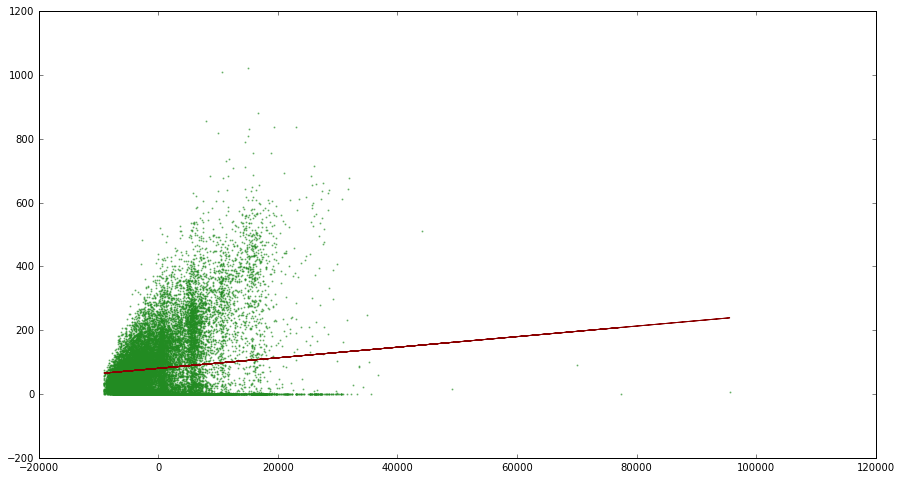

In [62]:
import matplotlib.pyplot as plt

regr = LinearRegression()
regr.fit(features_train_pca, targets_train)

def regr_eval(features, targets, classifier):
    # Print relevants statistics and plot 
    
    # The coefficients
    print "Coefficients: {}".format(classifier.coef_)
    
    # The mean squared error
    print("Mean squared error: %.2f"
      % np.mean((classifier.predict(features) - targets) ** 2))
    
    # Variance
    print('Variance score: %.2f' % classifier.score(features, targets))
    
    # Plot
    fig = plt.figure(1, figsize=(15, 8))
    ax = fig.add_subplot(111)
    plt.scatter(features, targets,  color='forestgreen', alpha = 0.5, s = 1)
    plt.plot(features, classifier.predict(features), color='darkred')

regr_eval(features_test_pca, targets_test, regr)

No matter how we look at it, the linear regression siply couldn't capture the trends in the data.

I still did it anyway, so that we could get some sense of what's going on, and compare it with the results later on.

# Group Classification

I put a 10 folds cross validation together with gridsearchcsv in a pipeline, to help streamline the search for algorithms and parameters. 

<img src='https://cloud.githubusercontent.com/assets/10266642/23798886/112a7514-05d9-11e7-9675-5623ff09e94a.JPG'>

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

def modelling(method, parameters, features, labels, score):
    """
    Given a method (algorithm) and a tuning parameters, train 
    the model and print the results
    """
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('features_selection', SelectKBest()),
            ('classifier', method)])
    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 10,
                      scoring = score)
    clf.fit(features, labels)
    print clf.best_score_
    print clf.best_params_
    return clf.best_estimator_

In [10]:
from sklearn.naive_bayes import GaussianNB
method = GaussianNB()
parameters = dict(features_selection__k = range(5, 8))
gnb_clf = modelling(method, parameters, features_train, labels_train, 'f1')

0.807136670787
{'features_selection__k': 5}


In [10]:
from sklearn.ensemble import ExtraTreesClassifier

method = ExtraTreesClassifier()
parameters = dict(features_selection__k=range(5, 8),
                  classifier__criterion=['gini'],
                  classifier__n_estimators=[10, 15, 30],
                  classifier__min_samples_split = [40, 100],
                  classifier__min_samples_leaf = [5, 10, 20])

ett_clf = modelling(method, parameters, features_train, labels_train, 'f1')

0.867126486556
{'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 40, 'classifier__n_estimators': 30, 'features_selection__k': 5, 'classifier__criterion': 'gini'}


In [11]:
from sklearn.ensemble import RandomForestClassifier

method = RandomForestClassifier()
parameters = dict(features_selection__k=range(5, 8),
                  classifier__n_estimators=[30, 50],
                  classifier__min_samples_split = [40, 100],
                  classifier__min_samples_leaf = [5, 100, 1000])
rfc_clf = modelling(method, parameters, features_train, labels_train, 'f1')

0.88181512498
{'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 50, 'features_selection__k': 7, 'classifier__min_samples_split': 40}


# Classification Evaluation

In [24]:
group_pred = rfc_clf.fit(features_train, labels_train).predict(features_test)

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print accuracy_score(labels_test, group_pred)
print f1_score(labels_test, group_pred)
print precision_score(labels_test, group_pred)
print recall_score(labels_test, group_pred)

0.803229770054
0.875888487855
0.826045190661
0.932133094542


# Groups Regression

In this analysis, I will only use linear regression. The goal is not to accurately predict the number of investors. The goal, is to build up a reasonable baseline, so that I will know what to expect when using more complicated models (in the future).

<img src='https://cloud.githubusercontent.com/assets/10266642/23798831/dbb64f48-05d8-11e7-803b-3d0a3a6e1279.JPG'>

In [26]:
def sep_target_groups(sep_labels, sep_array):
    """
    Given 2 numpy arrays with the same length, including one which 
    stored the labels information (2 labels only), use the index of
    the labels array to separate the other array.
    """
    # Store the index data
    groupa = []
    groupb = []

    for i in range(0, len(sep_labels)):
        if sep_labels[i] == 1.0:
            groupa.append(i)
        else:
            groupb.append(i)
    
    # Separate the arrays based on the index
    sep_groupa = sep_array[groupa]
    sep_groupb = sep_array[groupb]
    
    return sep_groupa, sep_groupb
    
targets_a_train, targets_b_train = sep_target_groups(labels_train, targets_train)
features_a_train, features_b_train = sep_target_groups(labels_train, features_train)

Separate the group predictions.

In [27]:
labels_a_pred, labels_b_pred = sep_target_groups(group_pred, group_pred)
labels_a_test, labels_b_test = sep_target_groups(group_pred, labels_test)
features_a_pred, features_b_pred = sep_target_groups(group_pred, features_test)
targets_a_pred, targets_b_pred = sep_target_groups(group_pred, targets_test)

Separate the labels and evaluate them

<img src='https://cloud.githubusercontent.com/assets/10266642/23798827/d9d5fdfe-05d8-11e7-9f3a-294c6acaebac.JPG'>

In [29]:
# Separate the true positive preds from the others for group A

pred_a_true_labels, pred_a_false_labels = sep_target_groups(labels_a_test, labels_a_test)
pred_a_true_features, pred_a_false_features = sep_target_groups(labels_a_test, features_a_pred)
pred_a_true_targets, pred_a_false_targets = sep_target_groups(labels_a_test, targets_a_pred)

# Separate the true positive preds from the others for group B

pred_b_false_labels, pred_b_true_labels = sep_target_groups(labels_b_test, labels_b_test)
pred_b_false_features, pred_b_true_features = sep_target_groups(labels_b_test, features_b_pred)
pred_b_false_targets, pred_b_true_targets = sep_target_groups(labels_b_test, targets_b_pred)

In [30]:
# pca transform for train features
features_a_train_pca = pca_trans(features_a_train)
features_b_train_pca = pca_trans(features_b_train)

# pca transform for test features
pred_a_true_features_pca = pca_trans(pred_a_true_features)
pred_a_false_features_pca = pca_trans(pred_a_false_features)

pred_b_true_features_pca = pca_trans(pred_b_true_features)
pred_b_false_features_pca = pca_trans(pred_b_false_features)

In [31]:
# model fitting
reg_a = LinearRegression()
reg_b = LinearRegression()
reg_a.fit(features_a_train_pca, targets_a_train)
reg_b.fit(features_b_train_pca, targets_b_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Coefficients: [ 0.00168943]
Mean squared error: 9883.08
Variance score: 0.11


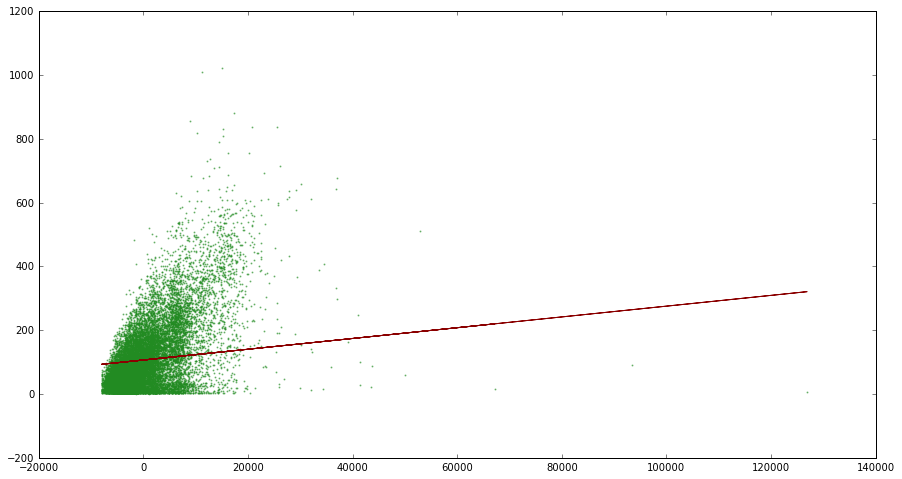

In [57]:
regr_eval(pred_a_true_features_pca, pred_a_true_targets, reg_a)

Coefficients: [ 0.00168943]
Mean squared error: 11280.38
Variance score: -9407848.12


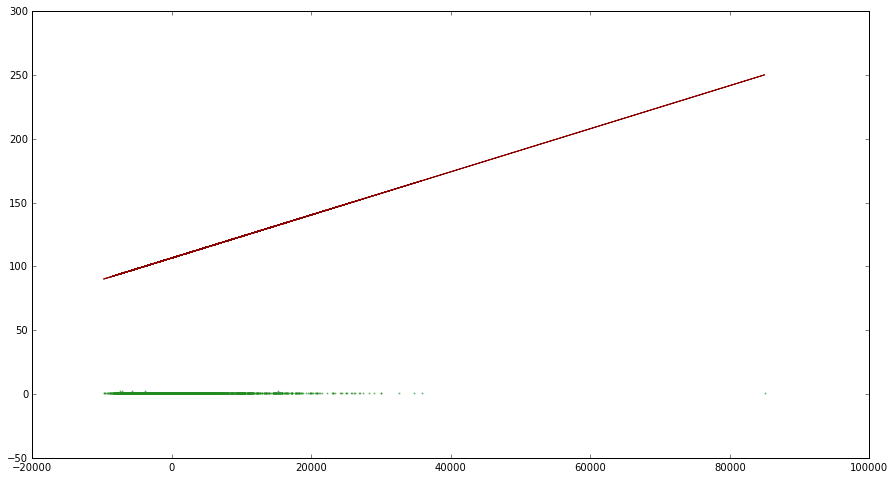

In [58]:
regr_eval(pred_a_false_features_pca, pred_a_false_targets, reg_a)

Coefficients: [-0.00021445]
Mean squared error: 690.84
Variance score: 0.01


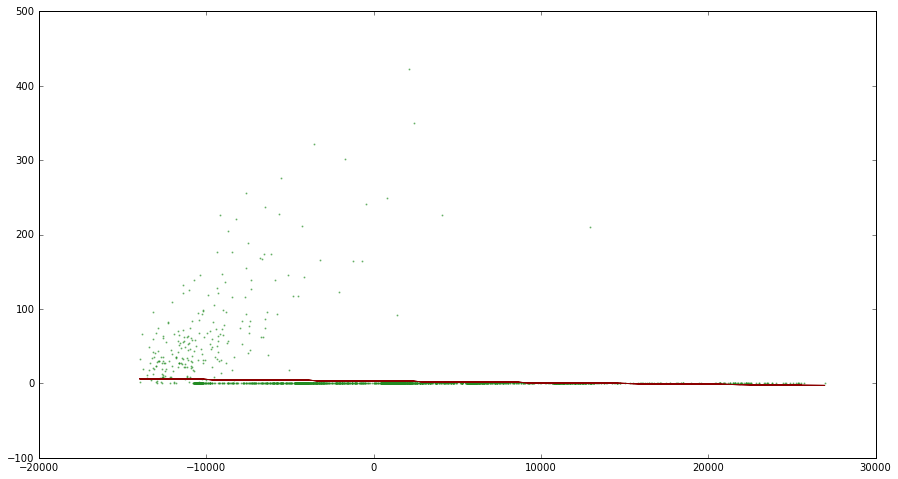

In [59]:
regr_eval(pred_b_true_features_pca, pred_b_true_targets, reg_b)


Coefficients: [-0.00021445]
Mean squared error: 34999.08
Variance score: -1.37


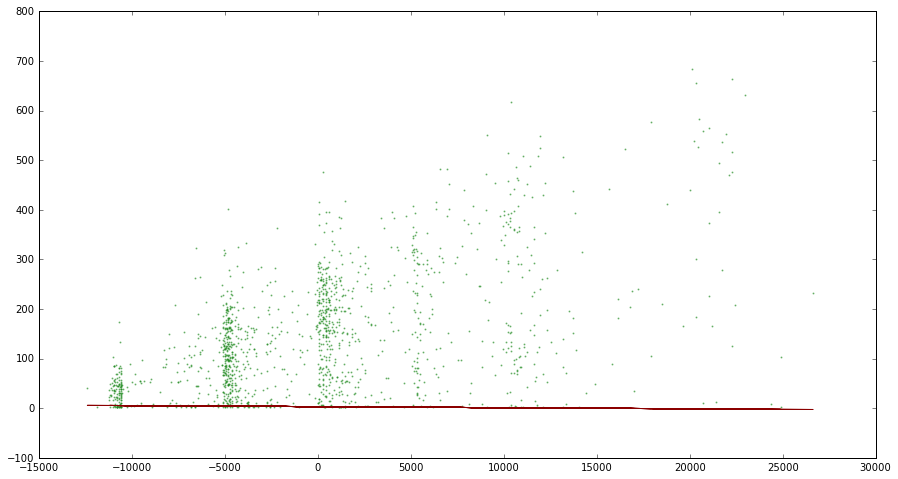

In [60]:
regr_eval(pred_b_false_features_pca, pred_b_false_targets, reg_b)


# Conclusion:

The linear regression models were able to better catch on to the data when separated to group A and group B.

It wasn't the best regression algorithm for the job but it was quick, and it allowed me to verify if the direction I took was a good one, and I will come back in the future, to fit more sophisticated regression models.